# Vehicle Routing Evaluator

This notebook evaluates TIG's vehicle routing algorithms against standard academic benchmark instances for the Vehicle Routing Problem with Time Windows (VRPTW). It measures algorithmic performance compared to known optimal or best-known solutions (BKS).

To ensure accuracy and consistency with known optimal solutions, all coordinates, travel times, distances, and time windows are scaled by a factor of 10. This scaling maintains the one-decimal precision and allows precise integer arithmetic during comparisons. This follows convention taken by [CVRPLIB](http://vrp.galgos.inf.puc-rio.br/index.php/en/plotted-instances?data=C101).

**Useful Links:**
  * [Challenge Description](https://tig.foundation/challenges/vehicle-routing)
  * [Challenge Code](https://github.com/tig-foundation/tig-monorepo/blob/main/tig-challenges/src/vehicle_routing.rs)

## 1. Setup Environment

### 1.1. Install Cargo

In [ ]:
import shutil
import os
if shutil.which("cargo") is None:
    print("cargo not found. Installing Rust and Cargo...")
    !curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh -s -- -y
    os.environ["PATH"] += f":{os.environ['HOME']}/.cargo/bin"
else:
    print("cargo is already installed.")

### 1.2. Clone tig-SOTA-metrics

In [ ]:
cwd = os.getcwd()
if cwd.endswith("tig-SOTA-metrics"):
    os.chdir("vehicle_routing_evaluator")
elif not cwd.endswith("vehicle_routing_evaluator"):
    !git clone https://github.com/tig-foundation/tig-SOTA-metrics
    os.chdir("tig-SOTA-metrics/vehicle_routing_evaluator")
else:
    print("already in the vehicle_routing_evaluator directory.")

### 1.3. Install Python Dependencies

In [ ]:
!pip install -r requirements.txt

### 1.4. Download Datasets

Currently, this evaluation supports one widely recognized benchmark set:
- **Homberger–Gehring Instances**: Extended benchmarks with larger-scale problems ranging from 200 to 1000 customers.

Test instances and best-known values are sourced from: [CVRPLIB](http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/)

In [ ]:
datasets = ["HG"]
for ds in datasets:
    if not os.path.exists(f"data/{ds}"):
        !cd data && python3 download_{ds}.py
    else:
        print(f"{ds} dataset already downloaded.")

## 2. Perform Evaluation

### 2.1. Fetch Top Earning Algorithms

Vehicle Routing was updated to a variant with timing windows in round 64

In [ ]:
import requests

API_URL = "https://mainnet-api.tig.foundation"

print("Fetching block")
block = requests.get(f"{API_URL}/get-block").json()["block"]
curr_round = block["details"]["round"]
print(f"Current Round: {curr_round}")

algorithms = {
    x['id']: x
    for x in requests.get(f"{API_URL}/get-algorithms?block_id={block['id']}").json()["algorithms"]
}

print(f"Fetching Top Earning Algorithms for Vehicle Routing from Rounds 64 to {curr_round - 1}")
top_algos = []
for r in range(64, curr_round):
    data = requests.get(f"{API_URL}/get-round-emissions?round={r}").json()
    a_id, earnings = max(
        filter(
            lambda x: x[0].startswith("c002"),
            map(
                lambda x: (x[0], int(x[1]) / 1e18),
                data["algorithms"].items()
            )
        ),
        key=lambda x: x[1]
    )
    a_name = algorithms[a_id]['details']['name']
    print(f"Round: {r}, Algo: {a_name}, Round Earnings: {earnings:.2f} TIG")
    top_algos.append((r, a_name))

### 2.2. (Optional) Evaluate Local Algorithm

If you want to evaluate an algorithm that has not been submitted to TIG (e.g. you are preparing Advance Submission):

1. Add your algorithm code to `src/{ALGORITHM_NAME}.rs`
2. Uncomment, edit, and run the below cell

In [ ]:
# top_algos.append((curr_round + 4, {ALGORITHM_NAME}))

### 2.3. Run Evaluations

Evaluation results are saved to `evaluations` folder as csv files

In [ ]:
unique_algos = set(x[1] for x in top_algos)
for a in unique_algos:
  for ds in datasets:
    !bash run.sh data/{ds} {a}

## 3. Plotting Results

Generate plots comparing:

* gap between SOTA algorithm results vs known optimal values
* gap between TIG algorithm results vs known optimal values

## 3.1. Load Data

In [5]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Load SOTA baseline
sota_df = pd.read_csv("data/HG/sota.csv", engine='python')
sota_df[['instance_type', 'size', '_']] = sota_df['instance'].str.split('_', expand=True)
sota_df['size'] = sota_df['size'].astype(int)

# Process all result files
results = []
for a in unique_algos:
    df = pd.read_csv(f"evaluations/c002_HG_{a}.csv", engine='python')
    df[['instance_type', 'size', '_']] = df['instance_name'].str.split('_', expand=True)
    df['size'] = df['size'].astype(int)
    df['algorithm'] = a
    results.append(df)
results_df = pd.concat(results, ignore_index=True)

mapping = pd.DataFrame(top_algos, columns=['round', 'algorithm'])
instance_types = sorted(results_df['instance_type'].unique())

## 3.2. Plot 1

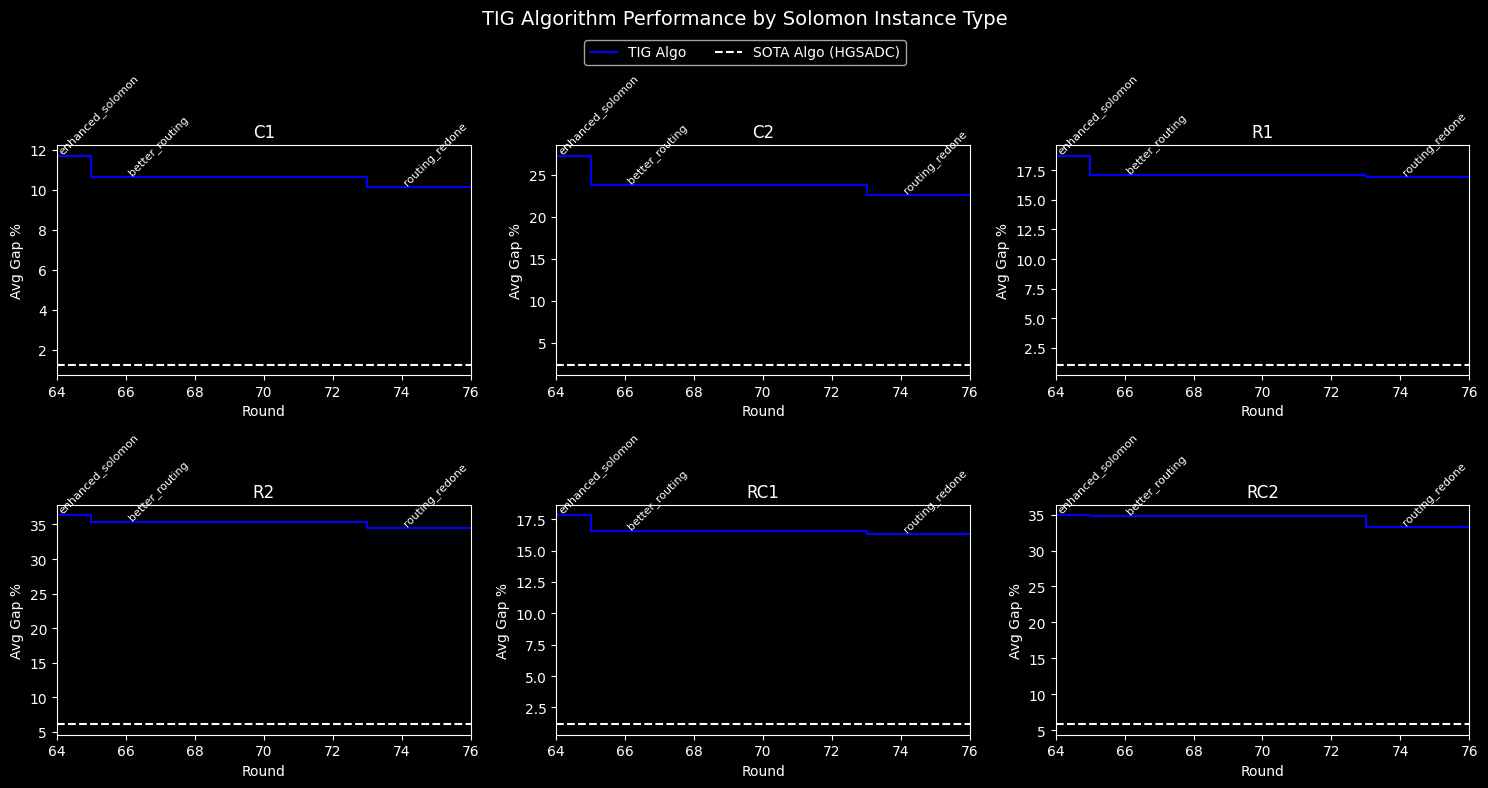

In [6]:
plot1_results_df = (
    results_df
        .groupby(['instance_type', 'algorithm'])
        .agg(avg_gap_percent=('gap_percent', 'mean'))
        .reset_index()
        .merge(mapping, on='algorithm', how='inner')
        .sort_values(['instance_type', 'round'])
)
plot1_sota_df = (
    sota_df
        .groupby(['instance_type'])
        .agg(avg_gap_percent=('rpd', 'mean'))
        .reset_index()
)

# Plot
cols, rows = 3, (len(instance_types) + 2) // 3
plt.style.use('dark_background')
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4), squeeze=False)
axes = axes.flatten()

for i, d in enumerate(instance_types):
    ax = axes[i]
    subset_df = plot1_results_df[plot1_results_df['instance_type'] == d].sort_values('round')

    ax.step(subset_df['round'], subset_df['avg_gap_percent'], 'b-', label='TIG Algo')

    # Label algorithm changes
    for j, (_, r) in enumerate(subset_df.iterrows()):
        if j == 0 or r['algorithm'] != subset_df.iloc[j-1]['algorithm']:
            ax.text(r['round'], r['avg_gap_percent'], r['algorithm'],
                   rotation=45, va='bottom', ha='left', fontsize=8)

    # SOTA gap to optimal value
    sota_gap = plot1_sota_df[plot1_sota_df['instance_type'] == d]['avg_gap_percent'].iloc[0]
    ax.axhline(sota_gap, linestyle='--', label='SOTA Algo (HGSADC)')
    ax.set_title(d)
    ax.set_xlabel('Round')
    ax.set_ylabel('Avg Gap %')
    ax.set_xlim(subset_df['round'].min(), subset_df['round'].max())

# Remove unused axes
for j in range(len(instance_types), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('TIG Algorithm Performance by Solomon Instance Type', fontsize=14)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.95), fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 3.3. Plot 2

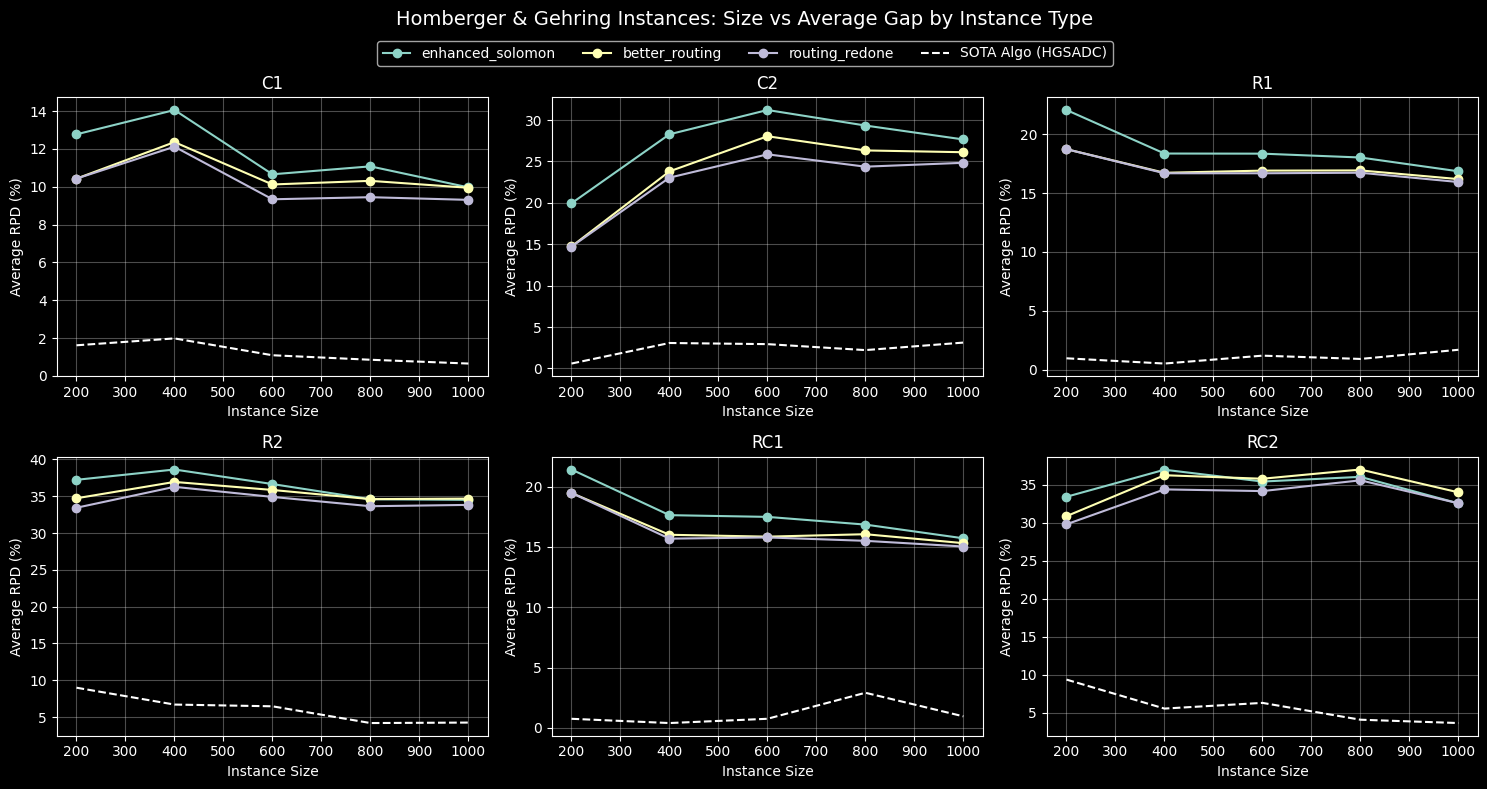

In [7]:
plot2_results_df = (
    results_df
        .groupby(['instance_type', 'size', 'algorithm'])
        .agg(avg_gap_percent=('gap_percent', 'mean'))
        .reset_index()
)
plot2_sota_df = (
    sota_df
        .groupby(['instance_type', 'size'])
        .agg(avg_gap_percent=('rpd', 'mean'))
        .reset_index()
)

# Plot for each source
cols = min(3, len(instance_types))
rows = (len(instance_types) + cols - 1) // cols

plt.style.use('dark_background')
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4), squeeze=False)
axes = axes.flatten()

for i, d in enumerate(instance_types):
    ax = axes[i]
    type_data = plot2_results_df[plot2_results_df['instance_type'] == d]

    for alg in unique_algos:
        alg_data = type_data[type_data['algorithm'] == alg]
        if not alg_data.empty:
            ax.plot(100*alg_data['size'], alg_data['avg_gap_percent'], 'o-', label=alg)

    sota = plot2_sota_df[plot2_sota_df['instance_type'] == d]
    ax.plot(100*sota['size'], sota['avg_gap_percent'], '--', color='white', label='SOTA Algo (HGSADC)')
    ax.set_title(d)
    ax.set_xlabel('Instance Size')
    ax.set_ylabel('Average RPD (%)')
    ax.grid(True, alpha=0.3)

# Remove unused subplots
for j in range(len(plot2_results_df), len(axes)):
    fig.delaxes(axes[j])

source_name = 'Homberger & Gehring'
fig.suptitle(f'{source_name} Instances: Size vs Average Gap by Instance Type', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.95), fontsize=10)

plt.show()